## Training an RNN to do binary addition

In [1]:
from __future__ import print_function, division, absolute_import

In [2]:
import numpy as np

import time

from sklearn.model_selection import train_test_split

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Generating data

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
int2bin = lambda n, width: np.array(list(np.binary_repr(n, width)), dtype=np.int32)

def generate_dataset(size=1000, width=None, concat=False):
    if width is None:
        width = int(np.ceil(np.log2(size)))
    max_int = 2**(width-1)

    ints = np.arange(max_int)
    n1 = np.random.permutation(ints)
    n2 = np.random.permutation(ints)
    
    if concat:
        X = np.zeros((size, width*2), dtype=np.int32)
    else:
        X = np.zeros((size, width, 2), dtype=np.int32)
    Y = np.zeros((size, width))
    
    for i, ns in enumerate(zip(n1, n2)):
        a,b = ns
        if concat:
            X[i] = np.concatenate((int2bin(a, width), int2bin(b, width)))
        else:
            X[i] = np.vstack((int2bin(a, width), int2bin(b, width))).T
        Y[i] = int2bin(a+b, width)
        if i+1==size:break
    return X,Y

In [6]:
bin_size = 12

X, Y = generate_dataset(10000, bin_size, concat=True)
X_train, X_valid, y_train, y_valid = train_test_split(X,Y)

## First: Linear Regression
<img src="http://www.biostathandbook.com/pix/regressionlollipop.gif">

In [7]:
reset_graph()

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size*2])
    Y = tf.placeholder(tf.float32, [None, bin_size])
    
    theta = tf.Variable(
        tf.random_normal(shape=[bin_size*2, bin_size])
    )
    bias = tf.Variable(
        tf.zeros(shape=[bin_size])
    )
    
    pred = tf.add(tf.matmul(X,theta),bias)
    loss = tf.reduce_mean(tf.abs(Y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(Y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(mse)
    
    init = tf.global_variables_initializer()

In [8]:
def run_session(graph, loss_func="MAE"):
    reset_graph()

    start = time.time()
    with tf.Session(graph=graph) as sess:
        init.run()
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(20001):
            feed_dict = {X:X_train, Y:y_train}
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%10 == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {X:X_valid, Y:y_valid}
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%1000==0:
                    print(
                        """Epoch {0}\n
                        Train {5}: {1}\n
                        Train MSE: {2}\n
                        Valid {5}: {3}\n
                        Valid MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value, loss_func))
                    print("~"*40)
    print("Took:",time.time()-start)
    return training, testing, training_mse, testing_mse

In [9]:
def plot_results(training, testing, training_mse, testing_mse, loss_func="MAE"):
    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(training.keys())
    data1 = [training[i] for i in xticks]
    data2 = [testing[i] for i in xticks]
    data3 = [training_mse[i] for i in xticks]
    data4 = [testing_mse[i] for i in xticks]

    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(loss_func)
    ax1.plot(xticks, data1, color=color1)
    ax1.plot(xticks, data2, color=color2)
    ax1.tick_params(axis='y')

    ax1.legend(["Train %s"%loss_func, "Valid %s"%loss_func])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color1 = 'tab:red'
    color2 = 'yellow'
    ax2.set_ylabel('MSE')
    ax2.plot(xticks, data3, color=color1)
    ax2.plot(xticks, data4, color=color2)
    ax2.tick_params(axis='y')
    ax2.legend(["Train MSE", "Valid MSE"], loc=9)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [10]:
training, testing, training_mse, testing_mse = run_session(graph, "MAE")

Epoch 0

                        Train MAE: 0.5001261234283447

                        Train MSE: 1.8824176788330078

                        Valid MAE: 0.4703592360019684

                        Valid MSE: 1.7330104112625122
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train MAE: 0.2411053627729416

                        Train MSE: 0.39435750246047974

                        Valid MAE: 0.23110944032669067

                        Valid MSE: 0.3742976188659668
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train MAE: 0.13873860239982605

                        Train MSE: 0.13284242153167725

                        Valid MAE: 0.13423535227775574

                        Valid MSE: 0.12939263880252838
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train MAE: 0.10791443288326263

                        Train MSE: 0.06429609656333923

                        Valid MAE: 0.1047198697924614

  

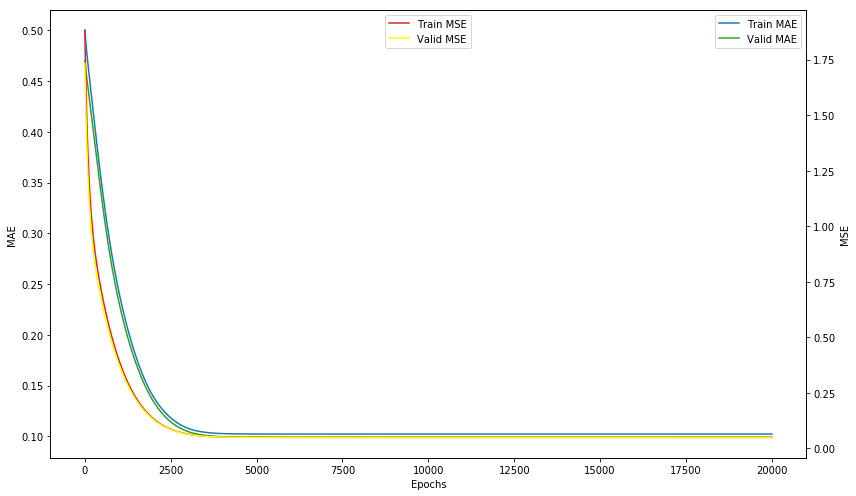

In [11]:
plot_results(training, testing, training_mse, testing_mse, "MAE")

## Second: Single-Layer Perceptron
<a href="http://www.saedsayad.com/artificial_neural_network_bkp.htm">
    Dr. Saed Sayad: Artificial Neural Network - Perceptron
   <img src="http://www.saedsayad.com/images/Perceptron_bkp_1.png">
    </a>

In [12]:
reset_graph()


graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None,bin_size*2])
    Y = tf.placeholder(tf.float32, shape=[None, bin_size])
    
    w = tf.Variable(tf.random_normal(shape=[bin_size*2, bin_size]))
    b = tf.Variable(tf.zeros(shape=[bin_size]))
    
    def model(data):
        return tf.add(tf.matmul(data,w),b)
    
    logits = model(X)
    pred = tf.nn.sigmoid(logits)
    loss = tf.reduce_mean(tf.abs(Y-pred))
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_y, logits=logits))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(Y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    init = tf.global_variables_initializer()

In [13]:
training, testing, training_mse, testing_mse = run_session(graph, "MAE")

Epoch 0

                        Train MAE: 0.5012584328651428

                        Train MSE: 0.28231945633888245

                        Valid MAE: 0.4996323585510254

                        Valid MSE: 0.279366672039032
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000

                        Train MAE: 0.31787973642349243

                        Train MSE: 0.1409364640712738

                        Valid MAE: 0.3190256953239441

                        Valid MSE: 0.14074872434139252
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000

                        Train MAE: 0.20802921056747437

                        Train MSE: 0.08955524116754532

                        Valid MAE: 0.2104281783103943

                        Valid MSE: 0.09101837873458862
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000

                        Train MAE: 0.1514337658882141

                        Train MSE: 0.07501546293497086

                        Valid MAE: 0.15438155829906464

   

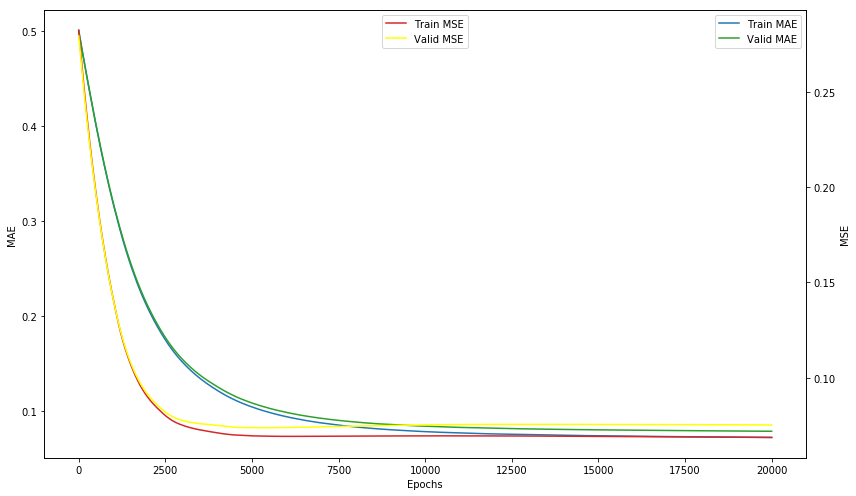

In [14]:
plot_results(training, testing, training_mse, testing_mse, "MAE")

### Third: Feedforward NN (no recurrence yet)

In [15]:
reset_graph()


graph_ff = tf.Graph()

with graph_ff.as_default():
    x1 = tf.placeholder(tf.float32, [None, bin_size])
    x2 = tf.placeholder(tf.float32, [None, bin_size])
    y = tf.placeholder(tf.float32, [None, bin_size])
    
    W1 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    W2 = tf.Variable(tf.random_normal([bin_size, bin_size]))
    
    b = tf.Variable(tf.random_normal([bin_size]))
    
    predictions = tf.nn.sigmoid(tf.add(tf.add(tf.matmul(x1, W1), tf.matmul(x2, W2)), b))
    
    loss = tf.reduce_mean(tf.abs(y - predictions))
    
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions))
    
    pred = tf.round(predictions)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [16]:
X1_train = X_train[:, :X_train.shape[1]//2]
X2_train = X_train[:, X_train.shape[1]//2:]

X1_valid = X_valid[:, :X_valid.shape[1]//2]
X2_valid = X_valid[:, X_valid.shape[1]//2:]

In [17]:
def run_session_rnn(graph, saver, loss_func="MAE", epochs=100, p_every=1, FF=False, path="binary_addition_ff"):
    start = time.time()
    reset_graph()
    with tf.Session(graph=graph) as sess, tf.device('/gpu'):
        init.run()
        train_maes = dict()
        valid_maes = dict()
        train_mses = dict()
        valid_mses = dict()
        
        
        for e in range(epochs+1):
            
            feed_dict = {y: y_train}
            if FF:
                feed_dict.update({x1:X1_train, x2:X2_train})
            else:
                feed_dict.update({X:X_train})

            _, mae_val_train, mse_val_train = sess.run(
                [optimizer, loss, mse], feed_dict=feed_dict)
            
            feed_dict = {y: y_valid}
            if FF:
                feed_dict.update({x1:X1_valid, x2:X2_valid})
            else:
                feed_dict.update({X:X_valid})
            
            mae_val_valid, mse_val_valid = sess.run([loss, mse], feed_dict=feed_dict)
            if e%p_every==0:
                print("Epoch: {0}\nTrain MAE:{1}\nValid MAE: {2}\nTrain MSE:{3}\nValid MSE:{4}".format(
                e,mae_val_train, mae_val_valid, mse_val_train, mse_val_valid))
                print("~"*50)
                train_maes[e] = mae_val_train
                train_mses[e] = mse_val_train
                
                valid_maes[e] = mae_val_valid
                valid_mses[e] = mse_val_valid
        
            if e%(p_every*10)==0:
                saver.save(sess, './{}'.format(path))
        print("Took: ", time.time()-start)
        return train_maes, train_mses, valid_maes, valid_mses, saver

In [53]:
def print_results(graph, saver, n=10, path="./binary_addition_ff", FF=False, scales=False):    
    with tf.Session(graph=graph) as sess:
        saver.restore(sess, path)
        _ = 0
        while _ < n:
            i = np.random.randint(len(X1_valid))
            y_ = y_valid[i]
            if sum(y_) == 0:
                continue
            _ += 1
            
            if FF:
                x1_ = X1_valid[i]
                x2_ = X2_valid[i]
                feed_dict = {x1:[x1_], x2:[x2_]}
            else:
                feed_dict = {X: [X_valid[i]]}
                
            ps = sess.run(pred,feed_dict=feed_dict)
            ps = np.reshape(ps, (-1))
            rounded = np.round(ps)
            if scales:
                rounded = int2bin(int(rounded), X_valid.shape[1])
                y_ = int2bin(int(y_), X_valid.shape[1])

            bin2int = lambda x: sum([2**i*n for i,n in enumerate(np.flip(x,0))])
            
            if not FF:
                x1_ = X_valid[i].T[0]
                x2_ = X_valid[i].T[1]
            a = bin2int(x1_)
            b = bin2int(x2_)
            c = bin2int(y_)
            d = bin2int(rounded)
            print(a, x1_)
            print("+")
            print(b, x2_)
            print("=")
            print(c, y_)
            print("Predicted\n{0} {1}".format(d, rounded))
            print("~"*10)

In [19]:
training, testing, training_mse, testing_mse, saver_ff = run_session_rnn(graph_ff, saver, FF=True, epochs=2000, p_every=10)

Epoch: 0
Train MAE:0.5672152638435364
Valid MAE: 0.5660459399223328
Train MSE:0.3784191906452179
Valid MSE:0.3760914206504822
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10
Train MAE:0.5493157505989075
Valid MAE: 0.5488324165344238
Train MSE:0.35895591974258423
Valid MSE:0.35721856355667114
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 20
Train MAE:0.5312414765357971
Valid MAE: 0.5315033793449402
Train MSE:0.34056445956230164
Valid MSE:0.3392695188522339
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 30
Train MAE:0.5131791830062866
Valid MAE: 0.5140908360481262
Train MSE:0.3226222097873688
Valid MSE:0.3218531608581543
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 40
Train MAE:0.49502742290496826
Valid MAE: 0.49654555320739746
Train MSE:0.30473217368125916
Valid MSE:0.304522305727005
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 50
Train MAE:0.47693008184432983
Valid MAE: 0.4788462221622467
Train MSE:0.2870032787322998
Valid M

Epoch: 510
Train MAE:0.11198578774929047
Valid MAE: 0.1153842955827713
Train MSE:0.06559091061353683
Valid MSE:0.06884773820638657
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 520
Train MAE:0.11064020544290543
Valid MAE: 0.11403102427721024
Train MSE:0.06542713940143585
Valid MSE:0.0686919242143631
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 530
Train MAE:0.1093461811542511
Valid MAE: 0.11274270713329315
Train MSE:0.06527364253997803
Valid MSE:0.06854806840419769
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 540
Train MAE:0.108128622174263
Valid MAE: 0.11151769012212753
Train MSE:0.06513478606939316
Valid MSE:0.06841672956943512
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 550
Train MAE:0.106951043009758
Valid MAE: 0.11034844815731049
Train MSE:0.06500710546970367
Valid MSE:0.06829781085252762
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 560
Train MAE:0.10583467781543732
Valid MAE: 0.109237439930439
Train MSE:0.0648874193

Epoch: 960
Train MAE:0.0832028016448021
Valid MAE: 0.0870218276977539
Train MSE:0.06258885562419891
Valid MSE:0.06631113588809967
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 970
Train MAE:0.08290516585111618
Valid MAE: 0.08674141764640808
Train MSE:0.06256017833948135
Valid MSE:0.06628923863172531
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 980
Train MAE:0.08262728899717331
Valid MAE: 0.0864708423614502
Train MSE:0.06253362447023392
Valid MSE:0.06626841425895691
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 990
Train MAE:0.08236144483089447
Valid MAE: 0.08619871735572815
Train MSE:0.06250963360071182
Valid MSE:0.06624597311019897
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1000
Train MAE:0.08209913969039917
Valid MAE: 0.08593504130840302
Train MSE:0.062487125396728516
Valid MSE:0.0662226676940918
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1010
Train MAE:0.08183757960796356
Valid MAE: 0.08567614108324051
Train MSE:0.06

Epoch: 1430
Train MAE:0.07473144680261612
Valid MAE: 0.07870227843523026
Train MSE:0.06185465678572655
Valid MSE:0.06573674082756042
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1440
Train MAE:0.07462313026189804
Valid MAE: 0.07860172539949417
Train MSE:0.06184177100658417
Valid MSE:0.06573735177516937
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1450
Train MAE:0.07451181858778
Valid MAE: 0.07850077003240585
Train MSE:0.061832427978515625
Valid MSE:0.06574071943759918
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1460
Train MAE:0.07440051436424255
Valid MAE: 0.07840541005134583
Train MSE:0.061818934977054596
Valid MSE:0.06574234366416931
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1470
Train MAE:0.07430250942707062
Valid MAE: 0.07831278443336487
Train MSE:0.06180733069777489
Valid MSE:0.06574518978595734
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1480
Train MAE:0.07419440895318985
Valid MAE: 0.07821948081254959
Train MS

Epoch: 1940
Train MAE:0.06999233365058899
Valid MAE: 0.07390487939119339
Train MSE:0.060766030102968216
Valid MSE:0.06452791392803192
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1950
Train MAE:0.06976177543401718
Valid MAE: 0.07362274825572968
Train MSE:0.0605679526925087
Valid MSE:0.06429295986890793
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1960
Train MAE:0.06948643922805786
Valid MAE: 0.07329080253839493
Train MSE:0.0603354275226593
Valid MSE:0.06398185342550278
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1970
Train MAE:0.06920452415943146
Valid MAE: 0.07295186072587967
Train MSE:0.060111843049526215
Valid MSE:0.063694529235363
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1980
Train MAE:0.06892994791269302
Valid MAE: 0.07260394841432571
Train MSE:0.059855662286281586
Valid MSE:0.06341683864593506
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1990
Train MAE:0.06861481070518494
Valid MAE: 0.07225540280342102
Train MS

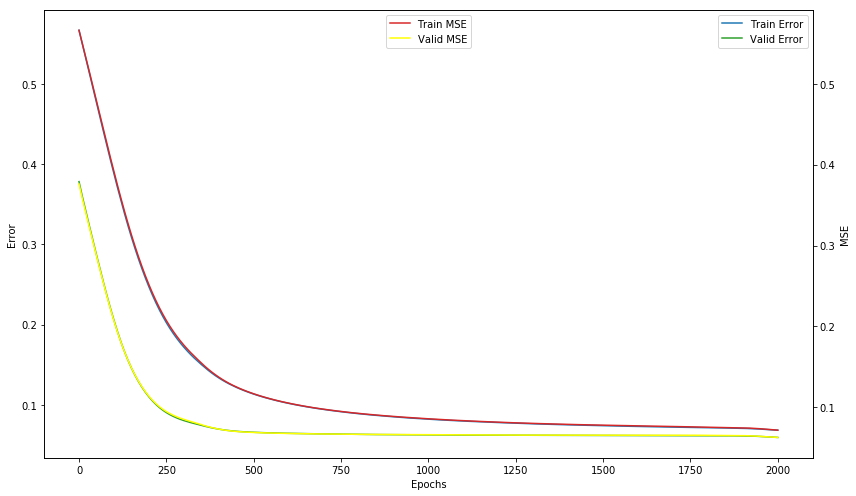

In [20]:
plot_results(training, testing, training_mse, testing_mse, "Error")

In [21]:
print_results(graph_ff, saver_ff, FF=True)

INFO:tensorflow:Restoring parameters from ./binary_addition_ff
1190 [0 1 0 0 1 0 1 0 0 1 1 0]
507 [0 0 0 1 1 1 1 1 1 0 1 1]
1697.0 [0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
Predicted
1198.0 [0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0.]
~~~~~~~~~~
1059 [0 1 0 0 0 0 1 0 0 0 1 1]
797 [0 0 1 1 0 0 0 1 1 1 0 1]
1856.0 [0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
Predicted
1548.0 [0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
~~~~~~~~~~
455 [0 0 0 1 1 1 0 0 0 1 1 1]
328 [0 0 0 1 0 1 0 0 1 0 0 0]
783.0 [0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
Predicted
15.0 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
~~~~~~~~~~
838 [0 0 1 1 0 1 0 0 0 1 1 0]
1873 [0 1 1 1 0 1 0 1 0 0 0 1]
2711.0 [1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1.]
Predicted
3094.0 [1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
~~~~~~~~~~
1975 [0 1 1 1 1 0 1 1 0 1 1 1]
1573 [0 1 1 0 0 0 1 0 0 1 0 1]
3548.0 [1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
Predicted
3324.0 [1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
~~~~~~~~~~
33 [0 0 0 0 0 0 1 0 0 0 0 1]
1025 [0 1 0 0 0 0 0 0 0 0 0 1]
1058.0 [0. 1. 0. 0. 

## Now let's try RNN
<a href="http://peterroelants.github.io/posts/rnn_implementation_part02/">
    Peter's notes: How to implement a recurrent neural network
<img src="https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png"></a>

In [22]:
bin_size = 12

X, Y = generate_dataset(10000, bin_size)
X_train, X_valid, y_train, y_valid = train_test_split(X,Y)

In [23]:
n_inputs = 2
h_size = 16

In [24]:
reset_graph()
graph_rnn = tf.Graph()
with graph_rnn.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size, n_inputs])  # num of instances, num of time steps, input size
    y = tf.placeholder(tf.float32, [None, bin_size])  # num of instances, num of bins

    
    basic_cell = tf.contrib.rnn.GRUCell(num_units=h_size, activation=tf.sigmoid)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#     top_h_state = tf.reshape(states[-1], (-1, h_size))
#     pred = tf.layers.dense(top_h_state, bin_size)
    stacked_rnn_outputs = tf.reshape(outputs, [-1, h_size])
    stacked_outputs = tf.contrib.layers.fully_connected(stacked_rnn_outputs, 1)
    pred = tf.reshape(stacked_outputs, [-1, bin_size])
    
    loss = tf.reduce_mean(tf.abs(y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, pred))
#     optimizer = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [25]:
train_maes, train_mses, valid_maes, valid_mses, saver_gru = run_session_rnn(
    graph_rnn, saver, epochs=200, p_every=2, path="binary_addition_gru")

Epoch: 0
Train MAE:0.5014815330505371
Valid MAE: 0.4897327721118927
Train MSE:0.2760869860649109
Valid MSE:0.2626769244670868
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
Train MAE:0.47915008664131165
Valid MAE: 0.4671908915042877
Train MSE:0.2511962652206421
Valid MSE:0.2384561449289322
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
Train MAE:0.4569384455680847
Valid MAE: 0.4447004199028015
Train MSE:0.22805850207805634
Valid MSE:0.21599175035953522
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
Train MAE:0.43471086025238037
Valid MAE: 0.42222708463668823
Train MSE:0.2066621333360672
Valid MSE:0.1952444612979889
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8
Train MAE:0.41249561309814453
Valid MAE: 0.39980605244636536
Train MSE:0.18699002265930176
Valid MSE:0.17622949182987213
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10
Train MAE:0.39036431908607483
Valid MAE: 0.37740957736968994
Train MSE:0.16903872787952423
Valid

Epoch: 94
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 96
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 98
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 100
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 102
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 104
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.1038

Epoch: 186
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 188
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 190
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 192
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 194
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.10386666655540466
Valid MSE:0.09920000284910202
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 196
Train MAE:0.10386666655540466
Valid MAE: 0.09920000284910202
Train MSE:0.1

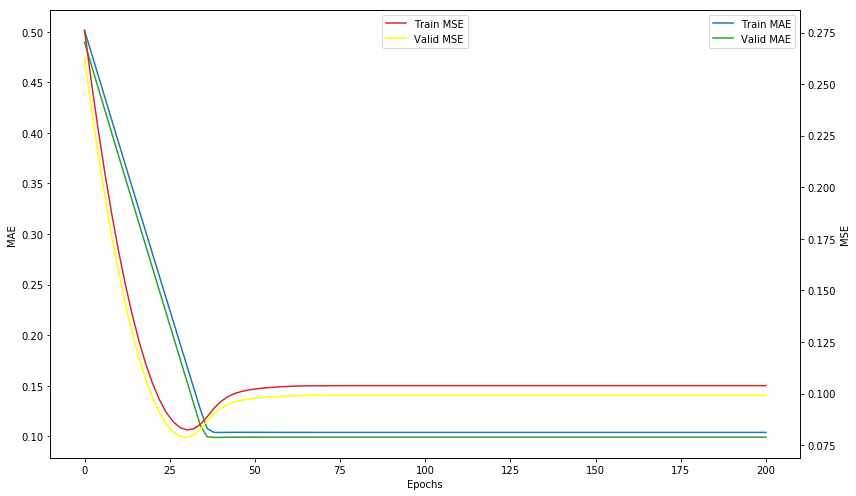

In [26]:
plot_results(train_maes, valid_maes, train_mses, valid_mses, "MAE")

In [27]:
print_results(graph_rnn, saver_gru, path="./binary_addition_gru")

INFO:tensorflow:Restoring parameters from ./binary_addition_gru
1527 [0 1 0 1 1 1 1 1 0 1 1 1]
1571 [0 1 1 0 0 0 1 0 0 0 1 1]
3098.0 [1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
1311 [0 1 0 1 0 0 0 1 1 1 1 1]
1921 [0 1 1 1 1 0 0 0 0 0 0 1]
3232.0 [1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
631 [0 0 1 0 0 1 1 1 0 1 1 1]
1706 [0 1 1 0 1 0 1 0 1 0 1 0]
2337.0 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
469 [0 0 0 1 1 1 0 1 0 1 0 1]
1868 [0 1 1 1 0 1 0 0 1 1 0 0]
2337.0 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
195 [0 0 0 0 1 1 0 0 0 0 1 1]
854 [0 0 1 1 0 1 0 1 0 1 1 0]
1049.0 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
Predicted
0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~
1801 [0 1 1 1 0 0 0 0 1 0 0 1]
1326 [0 1 0 1 0 0 1 0 1 1 1 0]
3127.0 [1. 1. 0. 0. 0. 0. 1.

### Using ouputs as scalars instead of binary sequences

In [28]:
bin2int_vec = np.array([2**i for i in range(bin_size-1,-1,-1)], dtype=np.float32)
train_Y_ints = np.dot(y_train, bin2int_vec)
test_Y_ints = np.dot(y_valid, bin2int_vec)

In [29]:
y_train = train_Y_ints.reshape(-1, 1)
y_valid = test_Y_ints.reshape(-1,1)

In [30]:
reset_graph()
graph_rnn = tf.Graph()
with graph_rnn.as_default():
    X = tf.placeholder(tf.float32, [None, bin_size, n_inputs])  # num of instances, num of time steps, input size
    y = tf.placeholder(tf.float32, [None, 1])  # num of instances, num of bins

    
    basic_cell = tf.contrib.rnn.GRUCell(num_units=h_size, activation=tf.sigmoid)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    
    stacked_rnn_outputs = tf.reshape(outputs, [-1, h_size])
    stacked_outputs = tf.contrib.layers.fully_connected(stacked_rnn_outputs, 1)
    pred_bin = tf.reshape(stacked_outputs, [-1, bin_size])

#     pred_bin = tf.layers.dense(top_h_state, bin_size, activation=tf.sigmoid)
    pred = tf.matmul(pred_bin, tf.reshape(bin2int_vec, [-1,1]))
    
    loss = tf.reduce_mean(tf.abs(y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(y, pred))
#     optimizer = tf.train.AdamOptimizer().minimize(loss)
    optimizer = tf.train.AdamOptimizer().minimize(mse)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [35]:
train_maes, train_mses, valid_maes, valid_mses, scaler_saver = run_session_rnn(
    graph_rnn, saver, epochs=10000, p_every=20, path="binary_addition_scaler")

Epoch: 0
Train MAE:1418.6253662109375
Valid MAE: 1402.5633544921875
Train MSE:2162911.75
Valid MSE:2109875.75
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 20
Train MAE:1055.7362060546875
Valid MAE: 1035.2266845703125
Train MSE:1251787.375
Valid MSE:1206760.5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 40
Train MAE:807.5849609375
Valid MAE: 786.4358520507812
Train MSE:937682.125
Valid MSE:896036.375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 60
Train MAE:694.3290405273438
Valid MAE: 675.7039794921875
Train MSE:869439.625
Valid MSE:826027.875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 80
Train MAE:668.2147827148438
Valid MAE: 652.0478515625
Train MSE:830753.75
Valid MSE:788563.4375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 100
Train MAE:663.6661376953125
Valid MAE: 648.2039184570312
Train MSE:793321.5
Valid MSE:753889.25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 120
Train MAE:652.6469116210938
Valid 

Epoch: 1000
Train MAE:21.122377395629883
Valid MAE: 20.674226760864258
Train MSE:1884.736572265625
Valid MSE:1890.36474609375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1020
Train MAE:20.590194702148438
Valid MAE: 20.124759674072266
Train MSE:1811.737060546875
Valid MSE:1815.0511474609375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1040
Train MAE:20.108335494995117
Valid MAE: 19.628990173339844
Train MSE:1741.82421875
Valid MSE:1743.0655517578125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1060
Train MAE:19.67052459716797
Valid MAE: 19.18427085876465
Train MSE:1674.734619140625
Valid MSE:1674.248046875
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1080
Train MAE:19.269987106323242
Valid MAE: 18.776134490966797
Train MSE:1610.50927734375
Valid MSE:1608.4837646484375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1100
Train MAE:18.90096664428711
Valid MAE: 18.398971557617188
Train MSE:1548.916259765625
Valid MSE:1545.63610

Epoch: 1940
Train MAE:10.58831787109375
Valid MAE: 10.562395095825195
Train MSE:459.3851318359375
Valid MSE:471.9672546386719
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1960
Train MAE:10.46710205078125
Valid MAE: 10.448698043823242
Train MSE:450.858642578125
Valid MSE:463.7735900878906
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 1980
Train MAE:10.348088264465332
Valid MAE: 10.33721923828125
Train MSE:442.61846923828125
Valid MSE:455.8326110839844
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2000
Train MAE:10.231467247009277
Valid MAE: 10.227840423583984
Train MSE:434.6498718261719
Valid MSE:448.1325988769531
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2020
Train MAE:10.11748218536377
Valid MAE: 10.120551109313965
Train MSE:426.9267272949219
Valid MSE:440.66119384765625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2040
Train MAE:10.00611400604248
Valid MAE: 10.015510559082031
Train MSE:419.4427185058594
Valid MSE:433.4

Epoch: 2880
Train MAE:6.741262435913086
Valid MAE: 6.776824951171875
Train MSE:224.48056030273438
Valid MSE:235.59503173828125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2900
Train MAE:6.685516834259033
Valid MAE: 6.720128059387207
Train MSE:221.40194702148438
Valid MSE:232.3603515625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2920
Train MAE:6.630566596984863
Valid MAE: 6.663943767547607
Train MSE:218.37106323242188
Valid MSE:229.16622924804688
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2940
Train MAE:6.576162338256836
Valid MAE: 6.608557224273682
Train MSE:215.37863159179688
Valid MSE:226.0137481689453
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2960
Train MAE:6.522549152374268
Valid MAE: 6.553903102874756
Train MSE:212.42198181152344
Valid MSE:222.8979034423828
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2980
Train MAE:6.4697489738464355
Valid MAE: 6.499828815460205
Train MSE:209.49966430664062
Valid MSE:219.819

Epoch: 3820
Train MAE:4.573496341705322
Valid MAE: 4.595058441162109
Train MSE:111.51883697509766
Valid MSE:117.2063980102539
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3840
Train MAE:4.533998966217041
Valid MAE: 4.555841445922852
Train MSE:109.68014526367188
Valid MSE:115.2938003540039
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3860
Train MAE:4.494477272033691
Valid MAE: 4.516630172729492
Train MSE:107.86319732666016
Valid MSE:113.4017105102539
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3880
Train MAE:4.45536994934082
Valid MAE: 4.477690696716309
Train MSE:106.07101440429688
Valid MSE:111.53067779541016
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3900
Train MAE:4.4164347648620605
Valid MAE: 4.4390034675598145
Train MSE:104.29375457763672
Valid MSE:109.68043518066406
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3920
Train MAE:4.377762317657471
Valid MAE: 4.400378704071045
Train MSE:102.54183197021484
Valid MSE:107.

Epoch: 4760
Train MAE:2.911228656768799
Valid MAE: 2.9420583248138428
Train MSE:45.959835052490234
Valid MSE:48.79777145385742
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4780
Train MAE:2.8875977993011475
Valid MAE: 2.9184134006500244
Train MSE:45.006988525390625
Valid MSE:47.790767669677734
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4800
Train MAE:2.8604464530944824
Valid MAE: 2.8918159008026123
Train MSE:44.0698127746582
Valid MSE:46.80930709838867
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4820
Train MAE:2.8327322006225586
Valid MAE: 2.8646655082702637
Train MSE:43.14730453491211
Valid MSE:45.84356689453125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4840
Train MAE:2.8036651611328125
Valid MAE: 2.836003065109253
Train MSE:42.23872375488281
Valid MSE:44.892852783203125
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4860
Train MAE:2.7737271785736084
Valid MAE: 2.80669903755188
Train MSE:41.34370040893555
Valid MSE:43

Epoch: 5680
Train MAE:1.964282512664795
Valid MAE: 2.0076396465301514
Train MSE:16.032421112060547
Valid MSE:17.510778427124023
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5700
Train MAE:1.9618773460388184
Valid MAE: 1.9910742044448853
Train MSE:15.656316757202148
Valid MSE:17.082361221313477
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5720
Train MAE:1.9282886981964111
Valid MAE: 1.9734845161437988
Train MSE:15.286336898803711
Valid MSE:16.720422744750977
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5740
Train MAE:1.9125937223434448
Valid MAE: 1.9776424169540405
Train MSE:14.90739917755127
Valid MSE:16.270780563354492
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5760
Train MAE:1.8947908878326416
Valid MAE: 1.9555031061172485
Train MSE:14.554201126098633
Valid MSE:15.895623207092285
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5780
Train MAE:1.8991916179656982
Valid MAE: 1.9294476509094238
Train MSE:14.207368850708008
Va

Epoch: 6600
Train MAE:1.2259737253189087
Valid MAE: 1.2478822469711304
Train MSE:5.578808307647705
Valid MSE:6.259424209594727
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6620
Train MAE:1.208542823791504
Valid MAE: 1.2342537641525269
Train MSE:5.471996307373047
Valid MSE:6.125553607940674
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6640
Train MAE:1.2030709981918335
Valid MAE: 1.2192856073379517
Train MSE:5.360457897186279
Valid MSE:6.01872444152832
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6660
Train MAE:1.1885744333267212
Valid MAE: 1.2234238386154175
Train MSE:5.257025718688965
Valid MSE:5.882197380065918
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6680
Train MAE:1.1759991645812988
Valid MAE: 1.208602786064148
Train MSE:5.161719799041748
Valid MSE:5.768838405609131
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6700
Train MAE:1.1631861925125122
Valid MAE: 1.1969126462936401
Train MSE:5.066312313079834
Valid MSE:5.66

Epoch: 7540
Train MAE:0.8041206002235413
Valid MAE: 0.8127632141113281
Train MSE:2.701524019241333
Valid MSE:2.89700984954834
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7560
Train MAE:0.7895539999008179
Valid MAE: 0.7880023717880249
Train MSE:2.6667640209198
Valid MSE:2.8662450313568115
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7580
Train MAE:0.7869816422462463
Valid MAE: 0.7853530049324036
Train MSE:2.6305062770843506
Valid MSE:2.8219187259674072
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7600
Train MAE:0.7890523672103882
Valid MAE: 0.790374219417572
Train MSE:2.601184368133545
Valid MSE:2.7762510776519775
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7620
Train MAE:0.7747077941894531
Valid MAE: 0.7736881971359253
Train MSE:2.565690517425537
Valid MSE:2.740957498550415
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7640
Train MAE:0.7719701528549194
Valid MAE: 0.7741929888725281
Train MSE:2.533440589904785
Valid MSE:2

Epoch: 8460
Train MAE:0.5850983262062073
Valid MAE: 0.5735623240470886
Train MSE:1.5267442464828491
Valid MSE:1.5644620656967163
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8480
Train MAE:0.5824878215789795
Valid MAE: 0.5695493221282959
Train MSE:1.5065945386886597
Valid MSE:1.5435985326766968
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8500
Train MAE:0.5788407921791077
Valid MAE: 0.5654018521308899
Train MSE:1.4889335632324219
Valid MSE:1.5249223709106445
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8520
Train MAE:0.5751966238021851
Valid MAE: 0.5616576075553894
Train MSE:1.47136652469635
Valid MSE:1.506032109260559
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8540
Train MAE:0.571553647518158
Valid MAE: 0.5580300092697144
Train MSE:1.454016923904419
Valid MSE:1.4871989488601685
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8560
Train MAE:0.5680742263793945
Valid MAE: 0.5544680953025818
Train MSE:1.4369202852249146
Valid

Epoch: 9380
Train MAE:0.44788095355033875
Valid MAE: 0.42548033595085144
Train MSE:0.9040133357048035
Valid MSE:0.9100054502487183
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9400
Train MAE:0.43714186549186707
Valid MAE: 0.42931410670280457
Train MSE:0.8942975997924805
Valid MSE:0.9032230377197266
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9420
Train MAE:0.4336271286010742
Valid MAE: 0.4198339879512787
Train MSE:0.884390115737915
Valid MSE:0.8921141624450684
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9440
Train MAE:0.4334430396556854
Valid MAE: 0.4220207929611206
Train MSE:0.8756996989250183
Valid MSE:0.8821888566017151
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9460
Train MAE:0.4324814975261688
Valid MAE: 0.416263610124588
Train MSE:0.8676127195358276
Valid MSE:0.8735387921333313
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9480
Train MAE:0.4262053966522217
Valid MAE: 0.4183953106403351
Train MSE:0.856046378612518

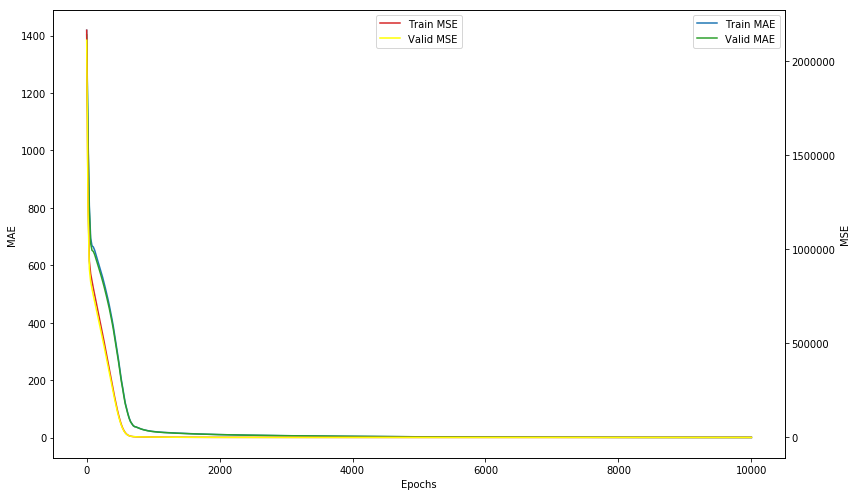

In [36]:
plot_results(train_maes, valid_maes, train_mses, valid_mses, "MAE")

In [54]:
print_results(graph_rnn, saver_gru, path="./binary_addition_scaler", scales=True)

INFO:tensorflow:Restoring parameters from ./binary_addition_scaler
339 [0 0 0 1 0 1 0 1 0 0 1 1]
+
63 [0 0 0 0 0 0 1 1 1 1 1 1]
=
402 [0 0 0 1 1 0 0 1 0 0 1 0]
Predicted
400 [0 0 0 1 1 0 0 1 0 0 0 0]
~~~~~~~~~~
468 [0 0 0 1 1 1 0 1 0 1 0 0]
+
1590 [0 1 1 0 0 0 1 1 0 1 1 0]
=
2058 [1 0 0 0 0 0 0 0 1 0 1 0]
Predicted
2057 [1 0 0 0 0 0 0 0 1 0 0 1]
~~~~~~~~~~
340 [0 0 0 1 0 1 0 1 0 1 0 0]
+
741 [0 0 1 0 1 1 1 0 0 1 0 1]
=
1081 [0 1 0 0 0 0 1 1 1 0 0 1]
Predicted
1080 [0 1 0 0 0 0 1 1 1 0 0 0]
~~~~~~~~~~
1437 [0 1 0 1 1 0 0 1 1 1 0 1]
+
809 [0 0 1 1 0 0 1 0 1 0 0 1]
=
2246 [1 0 0 0 1 1 0 0 0 1 1 0]
Predicted
2250 [1 0 0 0 1 1 0 0 1 0 1 0]
~~~~~~~~~~
801 [0 0 1 1 0 0 1 0 0 0 0 1]
+
189 [0 0 0 0 1 0 1 1 1 1 0 1]
=
990 [0 0 1 1 1 1 0 1 1 1 1 0]
Predicted
990 [0 0 1 1 1 1 0 1 1 1 1 0]
~~~~~~~~~~
1156 [0 1 0 0 1 0 0 0 0 1 0 0]
+
766 [0 0 1 0 1 1 1 1 1 1 1 0]
=
1922 [0 1 1 1 1 0 0 0 0 0 1 0]
Predicted
1925 [0 1 1 1 1 0 0 0 0 1 0 1]
~~~~~~~~~~
1704 [0 1 1 0 1 0 1 0 1 0 0 0]
+
1232 [0 1 0 0 1 1 0 